In [1]:
import pandas as pd
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


from scipy.stats import pearsonr
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clip_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from config import AGD20K_PATH, model_name

from VLM_model_dot_relative import MetricsTracker
from file_managing import (
    load_selected_samples,
    get_actual_path,
    get_gt_path,
    load_ground_truth,
    prompt_dict_obj,
    get_clipseg_heatmap,
    calculate_metrics
)

def min_max_normalize(arr):
    denom = arr.max() - arr.min()
    if denom == 0:
        return np.zeros_like(arr)
    return (arr - arr.min()) / (denom + 1e-8)

metrics_tracker_alloutput = MetricsTracker(name="all_output")

AGD20K_PATH

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


'/home/DATA/AGD20K'

In [3]:
df_output = pd.read_pickle("output_results/attention_result_full_output_32B_1.pkl")

In [4]:
df_output.columns

Index(['action', 'object', 'filename', 'description', 'output_sentence',
       'output_attentions'],
      dtype='object')

In [4]:
metrics_tracker_alloutput = MetricsTracker(name="all_output")
# 저장할 디렉토리 생성
output_dir = "./output_all_token_again"
os.makedirs(output_dir, exist_ok=True)
    
for i in range(24):
    i += 1
    df_output = pd.read_pickle(f"output_results/attention_result_full_output_32B_{i}.pkl")


    for idx, row in df_output.iterrows():
        # 1. 빈 히트맵 초기화 (31x31)
        sum_heatmap = np.zeros((31, 31), dtype=np.float32)

        object_name = row['object']
        action = row['action']
        filename = row['filename']
        output_description = row['output_sentence']
        output_attentions = row['output_attentions']
        
        file_name_real = f"{AGD20K_PATH}/Seen/testset/egocentric/{action}/{object_name}/{filename}"
        gt_path = f"{AGD20K_PATH}/Seen/testset/GT/{action}/{object_name}/{filename.split('.')[0]}.png"
            
        orig_img = cv2.imread(file_name_real)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        h, w, _ = orig_img.shape

        print(f"[{idx}] Processing: {action} - {object_name}")

        # --- CLIPSeg Mask 생성 ---
        clip_heatmap = get_clipseg_heatmap(
            file_name_real,
            clip_model,
            processor,
            object_name,
        )
        # CLIPSeg 결과를 31x31로 리사이즈 (평균 히트맵과 연산을 위해 크기 일치 필요)
        clip_heatmap_resized = cv2.resize(clip_heatmap, (31, 31), interpolation=cv2.INTER_LINEAR)
        clip_binary_mask = (clip_heatmap_resized > 0.15).astype(np.float32)

        # 2. 모든 어텐션 히트맵 합산
        total_heads_count = 0
        for token in output_attentions:
            attention_value = token['attentions']
            for each_attention in attention_value:
                layer = each_attention['layer']
                head = each_attention['head']
                
                if  1==1: #(layer == 26) and( head ==20) or ((layer == 24) and( head ==31)):
                  
                    sum_heatmap += each_attention['heatmap']
                    ## 부터 : 매 레이어헤드의 맥스값을 죽이기
                    # current_heatmap = each_attention['heatmap'].copy()

                    # # 2. 현재 히트맵에서 최대값을 찾습니다.
                    # max_value = np.max(current_heatmap)

                    # # 3. 불리언 인덱싱을 사용하여 최대값과 같은 모든 위치를 0으로 설정합니다.
                    # # (최대값이 여러 개일 경우 모두 0으로 바뀝니다.)
                    # current_heatmap[current_heatmap == max_value] = 0
                    # sum_heatmap += current_heatmap
                    # ## 까지
                    # minmax_each = min_max_normalize(each_attention['heatmap'])
                    # sum_heatmap += minmax_each
                    total_heads_count += 1
            
        # # 3. 평균 및 정규화
        average_heatmap = sum_heatmap / (total_heads_count + 1e-8)
        h_min, h_max = average_heatmap.min(), average_heatmap.max()
        avg_norm = (average_heatmap - h_min) / (h_max - h_min + 1e-8)

        ## 3. Robust minmax 
        # average_heatmap = sum_heatmap / (total_heads_count + 1e-8)

        # flat_heatmap = average_heatmap.flatten()
        # if len(flat_heatmap) > 1:
        #     robust_max = np.partition(flat_heatmap, -2)[-2]
        # else:
        #     robust_max = flat_heatmap.max()
            
        # h_min = average_heatmap.min()
        # # (3) 정규화 적용 (분모에 h_max 대신 robust_max 사용)
        # # 이렇게 하면 '진짜 최대값(1등)'은 1.0보다 큰 값이 되고, 나머지는 0~1 사이로 펴집니다.
        # avg_norm = (average_heatmap - h_min) / (robust_max - h_min + 1e-8)

        # # (4) 클리핑 (Clipping)
        # # 1.0을 넘어간 '진짜 최대값(Sink)'을 1.0으로 깎아줍니다.
        # avg_norm = np.clip(avg_norm, 0, 1.0)

        # ## ROBUST END!!!!!!!!

        # 마스킹 적용 (Attention * Mask)
        # avg_norm_masked = avg_norm * clip_binary_mask
        # CLIPSeg와 Hadamard Product
        avg_norm_cliped = avg_norm * clip_heatmap_resized
        gamma = 0.75  # 0
        avg_norm_cliped = np.power(avg_norm_cliped, gamma)
        # 리사이즈 및 블러링
        avg_norm_cliped_rescaled = cv2.resize(avg_norm_cliped, (w, h), interpolation=cv2.INTER_LINEAR)



        avg_norm_cliped_rescaled = cv2.resize(avg_norm_cliped, (w, h), interpolation=cv2.INTER_LINEAR)
        # 2. 커널 사이즈 결정 (이미지 크기의 약 5~10% 추천)
        sig = min(w, h) * 0.05 
        k_val = int(sig * 3) * 2 + 1 # 시그마에 따른 적절한 홀수 커널 사이즈 계산
        kernel_size = (k_val, k_val)

        # 3. 블러 적용 (float32 상태에서 수행)
        blur_map = cv2.GaussianBlur(avg_norm_cliped_rescaled, kernel_size, sig)

        # 4. 블러 후 다시 정규화 (값이 낮아질 수 있으므로)
        blur_map = min_max_normalize(blur_map)

        # 5. 시각화 방식 선택 (택 1)
        # 방법 A: matplotlib의 cmap 사용 (추천: 코드가 깔끔함)
        avg_norm_cliped_blur = blur_map

        ## resize
        avg_norm_cliped = cv2.resize(avg_norm_cliped, (w, h), interpolation=cv2.INTER_LINEAR)

        # 4. 시각화 (서브플롯 5개)
        fig, axes = plt.subplots(1, 6, figsize=(22, 6)) # 가로로 길게 설정
        

        ## GT metrics
        gt_map = load_ground_truth(gt_path)
        if gt_map is not None:
            metrics_dino  = calculate_metrics(avg_norm_cliped_blur, gt_map)
            metrics_tracker_alloutput.update(metrics_dino)
        else:
            print("NO GT!!!")
            continue
        metrics_tracker_alloutput.print_metrics(metrics_dino, filename)
        metrics_text = f"[{object_name} {action} {filename}]  KLD: {metrics_dino['KLD']:.4f} | SIM: {metrics_dino['SIM']:.4f} | NSS: {metrics_dino['NSS']:.4f}"
    


        # --- [핵심 추가] 전체 제목 설정 ---
        # object_name / action / filename 표시
        main_title = f"Object: {object_name}  |  Action: {action}  |  File: {filename} \n {metrics_text} \n {output_description}"

        fig.suptitle(main_title, fontsize=16, fontweight='bold', y=0.95)

        # (1) 원본 이미지
        img_real = cv2.imread(file_name_real)
        img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
        axes[0].imshow(img_real)
        axes[0].set_title(f"Original\n({object_name})")
        axes[0].axis('off')

        # (2) 전체 평균 Attention
        im1 = axes[1].imshow(avg_norm, cmap='jet', interpolation='bilinear')
        axes[1].set_title("Avg Attention")
        axes[1].axis('off')
        plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

        # (3) CLIPSeg Binary Mask (0 or 1)
        axes[2].imshow(clip_heatmap_resized, cmap='gray')
        axes[2].set_title("clip_heatmap_resized")
        axes[2].axis('off')

        # (4) Masked Attention (Attention x Mask)
        im3 = axes[3].imshow(avg_norm_cliped, cmap='jet', interpolation='bilinear')
        axes[3].set_title("Hadamard\nAttention")
        axes[3].axis('off')
        plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)


        # (4) Masked Attention (Attention x Mask)
        im3 = axes[4].imshow(avg_norm_cliped_blur, cmap='jet', interpolation='bilinear')
        axes[4].set_title("Blured")
        axes[4].axis('off')
        plt.colorbar(im3, ax=axes[4], fraction=0.046, pad=0.04)



        img_gt = cv2.imread(gt_path)
        img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
        axes[5].imshow(img_gt)
        axes[5].set_title("Ground Truth")

        axes[5].axis('off')

        # 5. 파일 저장
        save_path = os.path.join(output_dir, f"{object_name}_{action}_{filename.split('.')[0]}.png")
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        plt.close(fig)


[0] Processing: cut - apple


/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output apple_000054.jpg:
 all_output Current - KLD: 0.7167 | SIM: 0.6271 | NSS: 0.7104

Cumulative all_output  Averages over 1 samples:
Average - KLD: 0.7167 | SIM: 0.6271 | NSS: 0.7104

[1] Processing: eat - apple

Metrics for all_output apple_001541.jpg:
 all_output Current - KLD: 0.0368 | SIM: 0.9157 | NSS: 1.3227

Cumulative all_output  Averages over 2 samples:
Average - KLD: 0.3767 | SIM: 0.7714 | NSS: 1.0166

[2] Processing: peel - apple

Metrics for all_output apple_001541.jpg:
 all_output Current - KLD: 0.0330 | SIM: 0.9186 | NSS: 1.3129

Cumulative all_output  Averages over 3 samples:
Average - KLD: 0.2621 | SIM: 0.8205 | NSS: 1.1153

[3] Processing: hit - axe

Metrics for all_output axe_000961.jpg:
 all_output Current - KLD: 1.5394 | SIM: 0.2597 | NSS: 0.2154

Cumulative all_output  Averages over 4 samples:
Average - KLD: 0.5815 | SIM: 0.6803 | NSS: 0.8904

[4] Processing: hold - axe

Metrics for all_output axe_001552.jpg:
 all_output Current - KLD: 1.0134 | 

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output badminton_racket_002255.jpg:
 all_output Current - KLD: 1.8775 | SIM: 0.1791 | NSS: 0.2693

Cumulative all_output  Averages over 6 samples:
Average - KLD: 0.8695 | SIM: 0.5498 | NSS: 1.0162

[6] Processing: swing - badminton_racket

Metrics for all_output badminton_racket_003649.jpg:
 all_output Current - KLD: 4.1207 | SIM: 0.0245 | NSS: -0.4483

Cumulative all_output  Averages over 7 samples:
Average - KLD: 1.3339 | SIM: 0.4747 | NSS: 0.8070

[7] Processing: cut - banana

Metrics for all_output banana_002623.jpg:
 all_output Current - KLD: 0.2173 | SIM: 0.7456 | NSS: 1.4392

Cumulative all_output  Averages over 8 samples:
Average - KLD: 1.1944 | SIM: 0.5086 | NSS: 0.8860

[8] Processing: eat - banana

Metrics for all_output banana_002458.jpg:
 all_output Current - KLD: 0.0974 | SIM: 0.8499 | NSS: 1.7403

Cumulative all_output  Averages over 9 samples:
Average - KLD: 1.0725 | SIM: 0.5465 | NSS: 0.9809

[9] Processing: peel - banana

Metrics for all_output banana

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output baseball_002670.jpg:
 all_output Current - KLD: 0.3143 | SIM: 0.7220 | NSS: 3.4594

Cumulative all_output  Averages over 11 samples:
Average - KLD: 0.9944 | SIM: 0.5494 | NSS: 1.2484

[11] Processing: hit - baseball_bat

Metrics for all_output baseball_bat_001882.jpg:
 all_output Current - KLD: 2.0981 | SIM: 0.1550 | NSS: 0.3366

Cumulative all_output  Averages over 12 samples:
Average - KLD: 1.0864 | SIM: 0.5165 | NSS: 1.1724

[12] Processing: hold - baseball_bat

Metrics for all_output baseball_bat_002547.jpg:
 all_output Current - KLD: 2.5596 | SIM: 0.1062 | NSS: 0.7243

Cumulative all_output  Averages over 13 samples:
Average - KLD: 1.1997 | SIM: 0.4849 | NSS: 1.1379

[13] Processing: swing - baseball_bat

Metrics for all_output baseball_bat_001882.jpg:
 all_output Current - KLD: 2.0875 | SIM: 0.1569 | NSS: 0.3625

Cumulative all_output  Averages over 14 samples:
Average - KLD: 1.2631 | SIM: 0.4615 | NSS: 1.0826

[14] Processing: throw - basketball

Metrics 

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output bed_002880.jpg:
 all_output Current - KLD: 0.5454 | SIM: 0.5762 | NSS: 2.6867

Cumulative all_output  Averages over 16 samples:
Average - KLD: 1.1815 | SIM: 0.4720 | NSS: 1.3260

[16] Processing: sit_on - bed

Metrics for all_output bed_003622.jpg:
 all_output Current - KLD: 0.3861 | SIM: 0.6407 | NSS: 1.8596

Cumulative all_output  Averages over 17 samples:
Average - KLD: 1.1347 | SIM: 0.4819 | NSS: 1.3574

[17] Processing: lie_on - bench

Metrics for all_output bench_003727.jpg:
 all_output Current - KLD: 0.7588 | SIM: 0.4860 | NSS: 1.2631

Cumulative all_output  Averages over 18 samples:
Average - KLD: 1.1138 | SIM: 0.4821 | NSS: 1.3522

[18] Processing: sit_on - bench

Metrics for all_output bench_001877.jpg:
 all_output Current - KLD: 0.0827 | SIM: 0.8633 | NSS: 1.8650

Cumulative all_output  Averages over 19 samples:
Average - KLD: 1.0596 | SIM: 0.5022 | NSS: 1.3792

[19] Processing: push - bicycle

Metrics for all_output bicycle_002432.jpg:
 all_output Cu

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output bicycle_003046.jpg:
 all_output Current - KLD: 1.6089 | SIM: 0.2618 | NSS: 0.7448

Cumulative all_output  Averages over 21 samples:
Average - KLD: 1.1596 | SIM: 0.4721 | NSS: 1.2856

[21] Processing: sit_on - bicycle

Metrics for all_output bicycle_002100.jpg:
 all_output Current - KLD: 1.7292 | SIM: 0.2261 | NSS: 1.7344

Cumulative all_output  Averages over 22 samples:
Average - KLD: 1.1855 | SIM: 0.4609 | NSS: 1.3060

[22] Processing: look_out - binoculars

Metrics for all_output binoculars_003630.jpg:
 all_output Current - KLD: 0.8881 | SIM: 0.4365 | NSS: 0.7937

Cumulative all_output  Averages over 23 samples:
Average - KLD: 1.1725 | SIM: 0.4599 | NSS: 1.2837

[23] Processing: hold - book

Metrics for all_output book_001195.jpg:
 all_output Current - KLD: 0.8450 | SIM: 0.4618 | NSS: 1.1256

Cumulative all_output  Averages over 24 samples:
Average - KLD: 1.1589 | SIM: 0.4599 | NSS: 1.2771

[24] Processing: open - book

Metrics for all_output book_003044.jpg:


/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output bottle_003259.jpg:
 all_output Current - KLD: 1.6070 | SIM: 0.2234 | NSS: 1.9118

Cumulative all_output  Averages over 26 samples:
Average - KLD: 1.1601 | SIM: 0.4516 | NSS: 1.3449

[26] Processing: hold - bottle

Metrics for all_output bottle_001227.jpg:
 all_output Current - KLD: 0.3336 | SIM: 0.6852 | NSS: 2.0175

Cumulative all_output  Averages over 27 samples:
Average - KLD: 1.1295 | SIM: 0.4602 | NSS: 1.3698

[27] Processing: open - bottle

Metrics for all_output bottle_001033.jpg:
 all_output Current - KLD: 1.8157 | SIM: 0.1850 | NSS: 1.8094

Cumulative all_output  Averages over 28 samples:
Average - KLD: 1.1540 | SIM: 0.4504 | NSS: 1.3855

[28] Processing: pour - bottle

Metrics for all_output bottle_002780.jpg:
 all_output Current - KLD: 1.8654 | SIM: 0.2223 | NSS: 0.1392

Cumulative all_output  Averages over 29 samples:
Average - KLD: 1.1785 | SIM: 0.4425 | NSS: 1.3425

[29] Processing: hold - bowl

Metrics for all_output bowl_000546.jpg:
 all_output C

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output bowl_000134.jpg:
 all_output Current - KLD: 1.1420 | SIM: 0.4197 | NSS: 0.6075

Cumulative all_output  Averages over 31 samples:
Average - KLD: 1.1434 | SIM: 0.4535 | NSS: 1.3044

[31] Processing: wash - bowl

Metrics for all_output bowl_002825.jpg:
 all_output Current - KLD: 0.7980 | SIM: 0.4909 | NSS: 0.4576

Cumulative all_output  Averages over 32 samples:
Average - KLD: 1.1326 | SIM: 0.4546 | NSS: 1.2779

[32] Processing: eat - broccoli

Metrics for all_output broccoli_002796.jpg:
 all_output Current - KLD: 0.1824 | SIM: 0.7840 | NSS: 1.6829

Cumulative all_output  Averages over 33 samples:
Average - KLD: 1.1038 | SIM: 0.4646 | NSS: 1.2902

[33] Processing: take_photo - camera

Metrics for all_output camera_002534.jpg:
 all_output Current - KLD: 0.5665 | SIM: 0.5692 | NSS: 0.5202

Cumulative all_output  Averages over 34 samples:
Average - KLD: 1.0880 | SIM: 0.4677 | NSS: 1.2676

[34] Processing: cut - carrot

Metrics for all_output carrot_001443.jpg:
 all_ou

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output carrot_001443.jpg:
 all_output Current - KLD: 0.8659 | SIM: 0.4602 | NSS: 2.8074

Cumulative all_output  Averages over 36 samples:
Average - KLD: 1.0749 | SIM: 0.4677 | NSS: 1.3543

[36] Processing: peel - carrot

Metrics for all_output carrot_003707.jpg:
 all_output Current - KLD: 0.2755 | SIM: 0.7164 | NSS: 2.1073

Cumulative all_output  Averages over 37 samples:
Average - KLD: 1.0533 | SIM: 0.4744 | NSS: 1.3747

[37] Processing: take_photo - cell_phone

Metrics for all_output cell_phone_000601.jpg:
 all_output Current - KLD: 0.3193 | SIM: 0.6844 | NSS: 1.6487

Cumulative all_output  Averages over 38 samples:
Average - KLD: 1.0340 | SIM: 0.4799 | NSS: 1.3819

[38] Processing: talk_on - cell_phone

Metrics for all_output cell_phone_000601.jpg:
 all_output Current - KLD: 0.6908 | SIM: 0.5116 | NSS: 1.4622

Cumulative all_output  Averages over 39 samples:
Average - KLD: 1.0252 | SIM: 0.4807 | NSS: 1.3839

[39] Processing: text_on - cell_phone

Metrics for all_out

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output chair_002839.jpg:
 all_output Current - KLD: 0.8884 | SIM: 0.4537 | NSS: 1.1159

Cumulative all_output  Averages over 41 samples:
Average - KLD: 1.0177 | SIM: 0.4793 | NSS: 1.3830

[41] Processing: lie_on - couch

Metrics for all_output couch_003293.jpg:
 all_output Current - KLD: 0.7472 | SIM: 0.4840 | NSS: 1.5814

Cumulative all_output  Averages over 42 samples:
Average - KLD: 1.0113 | SIM: 0.4794 | NSS: 1.3877

[42] Processing: sit_on - couch

Metrics for all_output couch_000779.jpg:
 all_output Current - KLD: 0.7876 | SIM: 0.4704 | NSS: 2.0091

Cumulative all_output  Averages over 43 samples:
Average - KLD: 1.0061 | SIM: 0.4792 | NSS: 1.4022

[43] Processing: drink_with - cup

Metrics for all_output cup_000508.jpg:
 all_output Current - KLD: 0.6173 | SIM: 0.5356 | NSS: 2.6072

Cumulative all_output  Averages over 44 samples:
Average - KLD: 0.9973 | SIM: 0.4805 | NSS: 1.4296

[44] Processing: hold - cup

Metrics for all_output cup_002518.jpg:
 all_output Curr

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output cup_001535.jpg:
 all_output Current - KLD: 1.3317 | SIM: 0.3389 | NSS: 1.8586

Cumulative all_output  Averages over 46 samples:
Average - KLD: 1.0117 | SIM: 0.4739 | NSS: 1.4448

[46] Processing: sip - cup

Metrics for all_output cup_001864.jpg:
 all_output Current - KLD: 0.4902 | SIM: 0.6004 | NSS: 0.9295

Cumulative all_output  Averages over 47 samples:
Average - KLD: 1.0006 | SIM: 0.4765 | NSS: 1.4339

[47] Processing: wash - cup

Metrics for all_output cup_003621.jpg:
 all_output Current - KLD: 1.3963 | SIM: 0.2729 | NSS: 1.2918

Cumulative all_output  Averages over 48 samples:
Average - KLD: 1.0088 | SIM: 0.4723 | NSS: 1.4309

[48] Processing: throw - discus

Metrics for all_output discus_003558.jpg:
 all_output Current - KLD: 0.5734 | SIM: 0.5587 | NSS: 0.6702

Cumulative all_output  Averages over 49 samples:
Average - KLD: 0.9999 | SIM: 0.4741 | NSS: 1.4154

[49] Processing: beat - drum

Metrics for all_output drum_002586.jpg:
 all_output Current - KLD: 0

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output fork_000804.jpg:
 all_output Current - KLD: 0.9188 | SIM: 0.4251 | NSS: 1.5155

Cumulative all_output  Averages over 51 samples:
Average - KLD: 0.9972 | SIM: 0.4721 | NSS: 1.3922

[51] Processing: lift - fork

Metrics for all_output fork_001691.jpg:
 all_output Current - KLD: 1.5528 | SIM: 0.2579 | NSS: 0.3054

Cumulative all_output  Averages over 52 samples:
Average - KLD: 1.0079 | SIM: 0.4680 | NSS: 1.3713

[52] Processing: stick - fork

Metrics for all_output fork_000095.jpg:
 all_output Current - KLD: 0.8773 | SIM: 0.4358 | NSS: 1.8027

Cumulative all_output  Averages over 53 samples:
Average - KLD: 1.0055 | SIM: 0.4674 | NSS: 1.3795

[53] Processing: wash - fork

Metrics for all_output fork_001691.jpg:
 all_output Current - KLD: 0.9730 | SIM: 0.4122 | NSS: 1.8472

Cumulative all_output  Averages over 54 samples:
Average - KLD: 1.0049 | SIM: 0.4663 | NSS: 1.3881

[54] Processing: catch - frisbee

Metrics for all_output frisbee_000598.jpg:
 all_output Current

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output frisbee_001130.jpg:
 all_output Current - KLD: 0.4785 | SIM: 0.6048 | NSS: 0.5352

Cumulative all_output  Averages over 56 samples:
Average - KLD: 0.9896 | SIM: 0.4697 | NSS: 1.3485

[56] Processing: throw - frisbee

Metrics for all_output frisbee_003249.jpg:
 all_output Current - KLD: 0.5786 | SIM: 0.5592 | NSS: 0.5363

Cumulative all_output  Averages over 57 samples:
Average - KLD: 0.9824 | SIM: 0.4713 | NSS: 1.3343

[57] Processing: hold - golf_clubs

Metrics for all_output golf_clubs_000045.jpg:
 all_output Current - KLD: 1.4871 | SIM: 0.2705 | NSS: 0.9104

Cumulative all_output  Averages over 58 samples:
Average - KLD: 0.9911 | SIM: 0.4678 | NSS: 1.3270

[58] Processing: swing - golf_clubs

Metrics for all_output golf_clubs_001992.jpg:
 all_output Current - KLD: 2.3391 | SIM: 0.1328 | NSS: 0.3562

Cumulative all_output  Averages over 59 samples:
Average - KLD: 1.0139 | SIM: 0.4622 | NSS: 1.3105

[59] Processing: hit - hammer

Metrics for all_output hammer_0

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output hammer_000215.jpg:
 all_output Current - KLD: 1.4279 | SIM: 0.2618 | NSS: 1.8376

Cumulative all_output  Averages over 61 samples:
Average - KLD: 1.0306 | SIM: 0.4551 | NSS: 1.3056

[61] Processing: eat - hot_dog

Metrics for all_output hot_dog_002166.jpg:
 all_output Current - KLD: 0.2323 | SIM: 0.7400 | NSS: 1.1985

Cumulative all_output  Averages over 62 samples:
Average - KLD: 1.0178 | SIM: 0.4597 | NSS: 1.3039

[62] Processing: throw - javelin

Metrics for all_output javelin_001474.jpg:
 all_output Current - KLD: 1.3227 | SIM: 0.2919 | NSS: 3.2062

Cumulative all_output  Averages over 63 samples:
Average - KLD: 1.0226 | SIM: 0.4571 | NSS: 1.3341

[63] Processing: type_on - keyboard

Metrics for all_output keyboard_000439.jpg:
 all_output Current - KLD: 0.2336 | SIM: 0.7508 | NSS: 1.3933

Cumulative all_output  Averages over 64 samples:
Average - KLD: 1.0103 | SIM: 0.4617 | NSS: 1.3350

[64] Processing: cut_with - knife

Metrics for all_output knife_001749.j

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output knife_002682.jpg:
 all_output Current - KLD: 0.8234 | SIM: 0.4691 | NSS: 2.4474

Cumulative all_output  Averages over 66 samples:
Average - KLD: 1.0017 | SIM: 0.4629 | NSS: 1.3641

[66] Processing: stick - knife

Metrics for all_output knife_001072.jpg:
 all_output Current - KLD: 1.8844 | SIM: 0.1928 | NSS: 1.4233

Cumulative all_output  Averages over 67 samples:
Average - KLD: 1.0149 | SIM: 0.4588 | NSS: 1.3650

[67] Processing: wash - knife

Metrics for all_output knife_002720.jpg:
 all_output Current - KLD: 0.6477 | SIM: 0.5411 | NSS: 2.9257

Cumulative all_output  Averages over 68 samples:
Average - KLD: 1.0095 | SIM: 0.4601 | NSS: 1.3880

[68] Processing: type_on - laptop

Metrics for all_output laptop_000585.jpg:
 all_output Current - KLD: 1.4895 | SIM: 0.2837 | NSS: 0.7431

Cumulative all_output  Averages over 69 samples:
Average - KLD: 1.0164 | SIM: 0.4575 | NSS: 1.3786

[69] Processing: open - microwave

Metrics for all_output microwave_001049.jpg:
 all

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output motorcycle_003541.jpg:
 all_output Current - KLD: 1.4140 | SIM: 0.3044 | NSS: 0.9784

Cumulative all_output  Averages over 71 samples:
Average - KLD: 1.0259 | SIM: 0.4535 | NSS: 1.3674

[71] Processing: ride - motorcycle

Metrics for all_output motorcycle_002198.jpg:
 all_output Current - KLD: 1.2226 | SIM: 0.3400 | NSS: 1.3316

Cumulative all_output  Averages over 72 samples:
Average - KLD: 1.0287 | SIM: 0.4519 | NSS: 1.3669

[72] Processing: sit_on - motorcycle

Metrics for all_output motorcycle_000837.jpg:
 all_output Current - KLD: 1.5487 | SIM: 0.2452 | NSS: 2.2288

Cumulative all_output  Averages over 73 samples:
Average - KLD: 1.0358 | SIM: 0.4491 | NSS: 1.3787

[73] Processing: cut - orange

Metrics for all_output orange_001193.jpg:
 all_output Current - KLD: 0.7990 | SIM: 0.5986 | NSS: 1.2685

Cumulative all_output  Averages over 74 samples:
Average - KLD: 1.0326 | SIM: 0.4511 | NSS: 1.3772

[74] Processing: eat - orange

Metrics for all_output orange_0

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output orange_001193.jpg:
 all_output Current - KLD: 0.7812 | SIM: 0.6000 | NSS: 1.2703

Cumulative all_output  Averages over 76 samples:
Average - KLD: 1.0260 | SIM: 0.4550 | NSS: 1.3745

[76] Processing: wash - orange

Metrics for all_output orange_001193.jpg:
 all_output Current - KLD: 0.6182 | SIM: 0.6525 | NSS: 1.2713

Cumulative all_output  Averages over 77 samples:
Average - KLD: 1.0207 | SIM: 0.4575 | NSS: 1.3731

[77] Processing: open - oven

Metrics for all_output oven_001370.jpg:
 all_output Current - KLD: 1.1973 | SIM: 0.3361 | NSS: 1.2627

Cumulative all_output  Averages over 78 samples:
Average - KLD: 1.0229 | SIM: 0.4560 | NSS: 1.3717

[78] Processing: write - pen

Metrics for all_output pen_003590.jpg:
 all_output Current - KLD: 1.4154 | SIM: 0.2770 | NSS: 1.3538

Cumulative all_output  Averages over 79 samples:
Average - KLD: 1.0279 | SIM: 0.4537 | NSS: 1.3715

[79] Processing: boxing - punching_bag

Metrics for all_output punching_bag_001845.jpg:
 all

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output punching_bag_001639.jpg:
 all_output Current - KLD: 0.7627 | SIM: 0.4798 | NSS: 0.7286

Cumulative all_output  Averages over 81 samples:
Average - KLD: 1.0199 | SIM: 0.4552 | NSS: 1.3508

[81] Processing: open - refrigerator

Metrics for all_output refrigerator_002162.jpg:
 all_output Current - KLD: 1.3072 | SIM: 0.3108 | NSS: 0.6601

Cumulative all_output  Averages over 82 samples:
Average - KLD: 1.0234 | SIM: 0.4534 | NSS: 1.3424

[82] Processing: catch - rugby_ball

Metrics for all_output rugby_ball_003522.jpg:
 all_output Current - KLD: 0.3394 | SIM: 0.7017 | NSS: 0.6705

Cumulative all_output  Averages over 83 samples:
Average - KLD: 1.0152 | SIM: 0.4564 | NSS: 1.3343

[83] Processing: kick - rugby_ball

Metrics for all_output rugby_ball_002080.jpg:
 all_output Current - KLD: 0.1555 | SIM: 0.7871 | NSS: 1.0641

Cumulative all_output  Averages over 84 samples:
Average - KLD: 1.0050 | SIM: 0.4603 | NSS: 1.3311

[84] Processing: throw - rugby_ball

Metrics for

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output scissors_002479.jpg:
 all_output Current - KLD: 1.3309 | SIM: 0.2884 | NSS: 1.5949

Cumulative all_output  Averages over 86 samples:
Average - KLD: 1.0003 | SIM: 0.4615 | NSS: 1.3296

[86] Processing: hold - scissors

Metrics for all_output scissors_002479.jpg:
 all_output Current - KLD: 0.4931 | SIM: 0.6188 | NSS: 1.7980

Cumulative all_output  Averages over 87 samples:
Average - KLD: 0.9944 | SIM: 0.4633 | NSS: 1.3350

[87] Processing: carry - skateboard

Metrics for all_output skateboard_002668.jpg:
 all_output Current - KLD: 0.1426 | SIM: 0.8131 | NSS: 0.8282

Cumulative all_output  Averages over 88 samples:
Average - KLD: 0.9848 | SIM: 0.4673 | NSS: 1.3292

[88] Processing: hold - skateboard

Metrics for all_output skateboard_002387.jpg:
 all_output Current - KLD: 0.6495 | SIM: 0.5644 | NSS: 1.0053

Cumulative all_output  Averages over 89 samples:
Average - KLD: 0.9810 | SIM: 0.4684 | NSS: 1.3256

[89] Processing: jump - skateboard

Metrics for all_output s

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output skateboard_001460.jpg:
 all_output Current - KLD: 0.3380 | SIM: 0.6829 | NSS: 1.1399

Cumulative all_output  Averages over 91 samples:
Average - KLD: 0.9754 | SIM: 0.4697 | NSS: 1.3214

[91] Processing: carry - skis

Metrics for all_output skis_002829.jpg:
 all_output Current - KLD: 2.2222 | SIM: 0.1395 | NSS: -0.0814

Cumulative all_output  Averages over 92 samples:
Average - KLD: 0.9890 | SIM: 0.4661 | NSS: 1.3062

[92] Processing: hold - skis

Metrics for all_output skis_001357.jpg:
 all_output Current - KLD: 1.5414 | SIM: 0.2614 | NSS: 2.0798

Cumulative all_output  Averages over 93 samples:
Average - KLD: 0.9949 | SIM: 0.4639 | NSS: 1.3145

[93] Processing: jump - skis

Metrics for all_output skis_002829.jpg:
 all_output Current - KLD: 2.1252 | SIM: 0.1510 | NSS: 0.0255

Cumulative all_output  Averages over 94 samples:
Average - KLD: 1.0069 | SIM: 0.4606 | NSS: 1.3008

[94] Processing: pick_up - skis

Metrics for all_output skis_001547.jpg:
 all_output Curr

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output snowboard_001325.jpg:
 all_output Current - KLD: 1.4679 | SIM: 0.2720 | NSS: 1.9741

Cumulative all_output  Averages over 96 samples:
Average - KLD: 1.0210 | SIM: 0.4559 | NSS: 1.3075

[96] Processing: hold - snowboard

Metrics for all_output snowboard_001704.jpg:
 all_output Current - KLD: 1.7560 | SIM: 0.2194 | NSS: 0.0785

Cumulative all_output  Averages over 97 samples:
Average - KLD: 1.0285 | SIM: 0.4534 | NSS: 1.2948

[97] Processing: jump - snowboard

Metrics for all_output snowboard_001704.jpg:
 all_output Current - KLD: 1.0486 | SIM: 0.3921 | NSS: 0.2612

Cumulative all_output  Averages over 98 samples:
Average - KLD: 1.0288 | SIM: 0.4528 | NSS: 1.2842

[98] Processing: catch - soccer_ball

Metrics for all_output soccer_ball_003333.jpg:
 all_output Current - KLD: 0.1085 | SIM: 0.8602 | NSS: 1.3814

Cumulative all_output  Averages over 99 samples:
Average - KLD: 1.0195 | SIM: 0.4569 | NSS: 1.2852

[99] Processing: kick - soccer_ball

Metrics for all_outp

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output suitcase_002998.jpg:
 all_output Current - KLD: 3.3005 | SIM: 0.0602 | NSS: 0.4553

Cumulative all_output  Averages over 101 samples:
Average - KLD: 1.0330 | SIM: 0.4571 | NSS: 1.2874

[101] Processing: hold - suitcase

Metrics for all_output suitcase_003687.jpg:
 all_output Current - KLD: 1.9346 | SIM: 0.1960 | NSS: 1.4016

Cumulative all_output  Averages over 102 samples:
Average - KLD: 1.0418 | SIM: 0.4545 | NSS: 1.2886

[102] Processing: open - suitcase

Metrics for all_output suitcase_000520.jpg:
 all_output Current - KLD: 2.0940 | SIM: 0.1748 | NSS: 0.0483

Cumulative all_output  Averages over 103 samples:
Average - KLD: 1.0520 | SIM: 0.4518 | NSS: 1.2765

[103] Processing: pack - suitcase

Metrics for all_output suitcase_002212.jpg:
 all_output Current - KLD: 0.7885 | SIM: 0.4637 | NSS: 1.1316

Cumulative all_output  Averages over 104 samples:
Average - KLD: 1.0495 | SIM: 0.4519 | NSS: 1.2751

[104] Processing: pick_up - suitcase

Metrics for all_output s

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output surfboard_002422.jpg:
 all_output Current - KLD: 2.4637 | SIM: 0.1240 | NSS: -0.4740

Cumulative all_output  Averages over 106 samples:
Average - KLD: 1.0750 | SIM: 0.4459 | NSS: 1.2539

[106] Processing: hold - surfboard

Metrics for all_output surfboard_002631.jpg:
 all_output Current - KLD: 0.7462 | SIM: 0.4871 | NSS: 2.6849

Cumulative all_output  Averages over 107 samples:
Average - KLD: 1.0719 | SIM: 0.4463 | NSS: 1.2672

[107] Processing: jump - surfboard

Metrics for all_output surfboard_000658.jpg:
 all_output Current - KLD: 0.9315 | SIM: 0.4332 | NSS: 0.2904

Cumulative all_output  Averages over 108 samples:
Average - KLD: 1.0706 | SIM: 0.4461 | NSS: 1.2582

[108] Processing: lie_on - surfboard

Metrics for all_output surfboard_000221.jpg:
 all_output Current - KLD: 0.1018 | SIM: 0.8556 | NSS: 2.3627

Cumulative all_output  Averages over 109 samples:
Average - KLD: 1.0617 | SIM: 0.4499 | NSS: 1.2683

[109] Processing: sit_on - surfboard

Metrics for al

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output tennis_racket_002268.jpg:
 all_output Current - KLD: 3.5119 | SIM: 0.0585 | NSS: -0.4303

Cumulative all_output  Averages over 111 samples:
Average - KLD: 1.0760 | SIM: 0.4491 | NSS: 1.2439

[111] Processing: hold - tennis_racket

Metrics for all_output tennis_racket_001785.jpg:
 all_output Current - KLD: 1.5290 | SIM: 0.2506 | NSS: 1.7582

Cumulative all_output  Averages over 112 samples:
Average - KLD: 1.0801 | SIM: 0.4473 | NSS: 1.2484

[112] Processing: swing - tennis_racket

Metrics for all_output tennis_racket_003066.jpg:
 all_output Current - KLD: 2.6849 | SIM: 0.0820 | NSS: -0.3865

Cumulative all_output  Averages over 113 samples:
Average - KLD: 1.0943 | SIM: 0.4441 | NSS: 1.2340

[113] Processing: brush_with - toothbrush

Metrics for all_output toothbrush_001764.jpg:
 all_output Current - KLD: 1.7195 | SIM: 0.2090 | NSS: 1.7863

Cumulative all_output  Averages over 114 samples:
Average - KLD: 1.0998 | SIM: 0.4420 | NSS: 1.2388

[114] Processing: hold -

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Metrics for all_output toothbrush_001991.jpg:
 all_output Current - KLD: 1.2033 | SIM: 0.3274 | NSS: 1.9429

Cumulative all_output  Averages over 116 samples:
Average - KLD: 1.1055 | SIM: 0.4392 | NSS: 1.2445

[116] Processing: drink_with - wine_glass

Metrics for all_output wine_glass_003343.jpg:
 all_output Current - KLD: 1.6992 | SIM: 0.2166 | NSS: 0.7034

Cumulative all_output  Averages over 117 samples:
Average - KLD: 1.1106 | SIM: 0.4373 | NSS: 1.2399

[117] Processing: hold - wine_glass

Metrics for all_output wine_glass_002374.jpg:
 all_output Current - KLD: 1.0411 | SIM: 0.3823 | NSS: 1.0707

Cumulative all_output  Averages over 118 samples:
Average - KLD: 1.1100 | SIM: 0.4369 | NSS: 1.2385

[118] Processing: pour - wine_glass

Metrics for all_output wine_glass_000186.jpg:
 all_output Current - KLD: 1.3304 | SIM: 0.3087 | NSS: 0.8876

Cumulative all_output  Averages over 119 samples:
Average - KLD: 1.1118 | SIM: 0.4358 | NSS: 1.2355

[119] Processing: sip - wine_glass

Metric

In [5]:
gamma

0.75

In [ ]:
output all token all head : KLD: 1.1289 | SIM: 0.4459 | NSS: 1.1993 //  
output all token all head_exp074 : KLD: 1.1157 | SIM: 0.4341 | NSS: 1.2325
robust minmax for final head info :  KLD: 1.1253 | SIM: 0.4459 | NSS: 1.2194
robust minmax for each head info :  KLD: 1.1189 | SIM: 0.4462 | NSS: 1.2231
매번 민맥스해서 더하기 : Average - KLD: 1.1512 | SIM: 0.4400 | NSS: 1.1552


output all token 26/20 :KLD: 1.3174 | SIM: 0.4202 | NSS: 1.0314
output all token 26/20 24/31 :- KLD: 1.2225 | SIM: 0.4379 | NSS: 1.1262 // KLD: 1.1276 | SIM: 0.4557 | NSS: 1.2209

output last token :  KLD: 1.1882 | SIM: 0.4344 | NSS: 1.0598
output first token : KLD: 1.2154 | SIM: 0.4252 | NSS: 1.0297

output token contrastive :  KLD: 1.1382 | SIM: 0.4453 | NSS: 1.1705
top1 - last1 threshold 95% :  KLD: 1.1613 | SIM: 0.4380 | NSS: 1.1355  // 너무 작은 부분 다시 1.0996 | SIM: 0.4529 | NSS: 1.2712
top 1 token only : KLD: 1.0901 | SIM: 0.4564 | NSS: 1.2929 (s_img로 뽑은)
top 1 token + clipseg mine :KLD: 1.1725 | SIM: 0.4323 | NSS: 1.2203
top 1 token + layer minmax: KLD: 1.1330 | SIM: 0.4401 | NSS: 1.1897
top 1 token + final L26H20: KLD: 1.4006 | SIM: 0.4078 | NSS: 0.9742
top 1 each minmax: KLD: 1.0930 | SIM: 0.4547 | NSS: 1.2871
top 1 token + following : Average - KLD: 1.0988 | SIM: 0.4517 | NSS: 1.2744
top 1 0.03 blur  : KLD: 1.1640 | SIM: 0.4427 | NSS: 1.1683
last 1 token only :KLD: 1.2832 | SIM: 0.4078 | NSS: 0.9951
top1 26/20        :  KLD: 1.3155 | SIM: 0.4203 | NSS: 1.0148
top1 Layer20~45   :  KLD: 1.1003 | SIM: 0.4515 | NSS: 1.2551
top1 26/all       :  KLD: 1.2185 | SIM: 0.4306 | NSS: 1.0700
top1 26/20 & 2431:  KLD: 1.2553 | SIM: 0.4421 | NSS: 1.1785 
top3 26/20 & 2431:  KLD: 1.1720 | SIM: 0.4537 | NSS: 1.2255  
top 3 token only :  KLD: 1.0980 | SIM: 0.4533 | NSS: 1.2713
top 5 token only :  KLD :1.1030 | SIM: 0.4507 | NSS: 1.2490
cossinm 으로 뽑은top 1 token only :  KLD: 1.1265 | SIM: 0.4557 | NSS: 1.2487 

In [ ]:
Clipseg만한거 : 
|KLD|SIM|NSS|
|1.393|0.343|1.090|

Clipseg만한거 - 생성된단어로!! 
 KLD: 1.3109 | SIM: 0.3916 | NSS: 1.0561

In [1]:
import numpy as np

In [4]:
np.power(0.1,0.75)

np.float64(0.1778279410038923)

In [3]:
np.power(2,0.75)

np.float64(1.681792830507429)

In [ ]:

# 저장할 디렉토리 생성
output_dir = "./output_average"
os.makedirs(output_dir, exist_ok=True)

for idx, row in df_output.iterrows():
    # 1. 빈 히트맵 초기화 (31x31)
    sum_heatmap = np.zeros((31, 31), dtype=np.float32)

    object_name = row['object']
    action = row['action']
    filename = row['filename']
    output_attentions = row['output_attentions']
    
    file_name_real = f"{AGD20K_PATH}/Seen/testset/egocentric/{action}/{object_name}/{filename}"
    gt_path = f"{AGD20K_PATH}/Seen/testset/GT/{action}/{object_name}/{filename.split('.')[0]}.png"
    
    print(f"[{idx}] Processing: {action} - {object_name}")

    # --- CLIPSeg Mask 생성 ---
    clip_heatmap = get_clipseg_heatmap(
        file_name_real,
        clip_model,
        processor,
        object_name,
    )
    # CLIPSeg 결과를 31x31로 리사이즈 (평균 히트맵과 연산을 위해 크기 일치 필요)
    clip_heatmap_resized = cv2.resize(clip_heatmap, (31, 31), interpolation=cv2.INTER_LINEAR)
    clip_binary_mask = (clip_heatmap_resized > 0.15).astype(np.float32)

    # 2. 모든 어텐션 히트맵 합산
    total_heads_count = 0
    for token in output_attentions:
        attention_value = token['attentions']
        for each_attention in attention_value:
            sum_heatmap += each_attention['heatmap']
            total_heads_count += 1
        
    # 3. 평균 및 정규화
    average_heatmap = sum_heatmap / (total_heads_count + 1e-8)
    h_min, h_max = average_heatmap.min(), average_heatmap.max()
    avg_norm = (average_heatmap - h_min) / (h_max - h_min + 1e-8)

    # 마스킹 적용 (Attention * Mask)
    avg_norm_masked = avg_norm * clip_binary_mask

    # 4. 시각화 (서브플롯 5개)
    fig, axes = plt.subplots(1, 5, figsize=(22, 6)) # 가로로 길게 설정
    
    # --- [핵심 추가] 전체 제목 설정 ---
    # object_name / action / filename 표시
    main_title = f"Object: {object_name}  |  Action: {action}  |  File: {filename}"
    fig.suptitle(main_title, fontsize=16, fontweight='bold', y=0.95)

    # (1) 원본 이미지
    img_real = cv2.imread(file_name_real)
    img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img_real)
    axes[0].set_title(f"Original\n({object_name})")
    axes[0].axis('off')

    # (2) 전체 평균 Attention
    im1 = axes[1].imshow(avg_norm, cmap='jet', interpolation='bilinear')
    axes[1].set_title("Avg Attention")
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # (3) CLIPSeg Binary Mask (0 or 1)
    axes[2].imshow(clip_binary_mask, cmap='gray')
    axes[2].set_title("CLIPSeg Mask\n(Threshold 0.15)")
    axes[2].axis('off')

    # (4) Masked Attention (Attention x Mask)
    im3 = axes[3].imshow(avg_norm_masked, cmap='jet', interpolation='bilinear')
    axes[3].set_title("Masked\nAttention")
    axes[3].axis('off')
    plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

    # (5) Ground Truth
    if os.path.exists(gt_path):
        img_gt = cv2.imread(gt_path)
        img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
        axes[4].imshow(img_gt)
        axes[4].set_title("Ground Truth")
    else:
        axes[4].text(0.5, 0.5, "GT Not Found", ha='center')
    axes[4].axis('off')

    # 5. 파일 저장
    save_path = os.path.join(output_dir, f"{object_name}_{action}_{filename.split('.')[0]}.png")
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close(fig)



[0] Processing: cut - apple
[1] Processing: eat - apple
[2] Processing: peel - apple
[3] Processing: hit - axe
[4] Processing: hold - axe
완료! 저장 위치: ./output_average


In [ ]:
for idx, row in df_output.iterrows():

    # 1. 빈 히트맵 초기화 (31x31)
    sum_heatmap = np.zeros((31, 31), dtype=np.float32)

    object_name = row['object']
    action = row['action']
    filename = row['filename']
    llm_output = row['output_sentence']
    output_attentions = row['output_attentions']
    file_name_real = f"{AGD20K_PATH}/Seen/testset/egocentric/{action}/{object_name}/{filename}"
    gt_path =  f"{AGD20K_PATH}/Seen/testset/GT/{action}/{object_name}/{filename.split('.')[0]}.png"
    print(f"Processing image {idx}, object : {object_name}, action : {action} // Total tokens for output sentence : {len(output_attentions)}")
    

    clip_heatmap = get_clipseg_heatmap(
    file_name_real,
    clip_model, # Pass the model object (now on GPU)
    processor,
    object_name,
    )
    # 2. CLIPSeg 히트맵을 0,1의 바이너리마스크로 만듬
    clip_binary_mask = (clip_heatmap > 0.15).astype(np.float32)


    for token_idx, token in enumerate(output_attentions):
        attention_value = token['attentions']
        for each_attention in attention_value:
            each_layer = each_attention['layer']
            each_head = each_attention['head']
            # print(f"Layer : {each_layer}, Head : {each_head}, heatmap size : {np.shape(each_attention['heatmap'])}")
            each_heatmap = each_attention['heatmap']
            sum_heatmap += each_heatmap
        
    # 3. 평균 히트맵 계산 (선택 사항: 정규화를 하면 결과는 동일함)
    average_heatmap = sum_heatmap / len(attention_value)

    # 4. Min-Max Normalization (0 ~ 1 사이로 맞춤)
    heatmap_min = average_heatmap.min()
    heatmap_max = average_heatmap.max()

    # 분모가 0이 되는 것을 방지하기 위해 아주 작은 값(1e-8)을 더해줄 수 있습니다.
    average_heatmap_normalized = (average_heatmap - heatmap_min) / (heatmap_max - heatmap_min + 1e-8)

Processing image 0, object : apple, action : cut // Total tokens for output sentence : 33


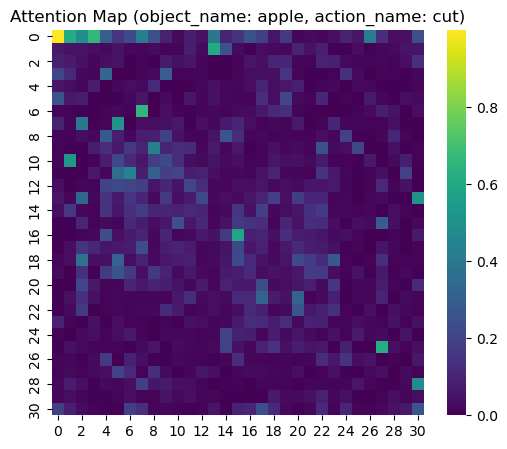

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# inside_heatmap이 (31, 31)이라고 가정
plt.figure(figsize=(6, 5))
sns.heatmap(average_heatmap_normalized, cmap='viridis') # 또는 'jet', 'hot' 등 선호하는 컬러맵 사용
plt.title(f"Attention Map (object_name: {object_name}, action_name: {action})")
plt.show()